<a href="https://colab.research.google.com/github/wisnupri/Image-Classification-of-Sidewalk-Function-Violations/blob/main/UAS_22_01_85_0016_WISNU_PRIAMBODO_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### UJIAN AKHIR SEMESTER
### Matakuliah	: MESIN PEMBELAJAR UNTUK BISNIS
### Nama		: WISNU PRIAMBODO
### NIM		: 22.01.85.0016
### Dosen		: Dr. Drs. Eri Zuliarso, M.Kom

In [ ]:
import os
import zipfile

#local_zip = '/content/drive/MyDrive/Datasets/trotoar_full.zip' #130data
#local_zip = '/content/drive/MyDrive/Datasets/trotoar_new2.zip' #20data
#local_zip = '/content/drive/MyDrive/Datasets/trotoar_58.zip' #58data
local_zip = '/content/drive/MyDrive/Datasets/trotoar_3label.zip' #3_label
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data')
zip_ref.close()

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/sample_data/trotoar'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/sample_data/trotoar/pemotor/pemotor (1).webp
/content/sample_data/trotoar/pemotor/pemotor (76).jpg
/content/sample_data/trotoar/pemotor/pemotor (64).jpg
/content/sample_data/trotoar/pemotor/pemotor (93).jpg
/content/sample_data/trotoar/pemotor/pemotor (60).jpg
/content/sample_data/trotoar/pemotor/pemotor (77).jpg
/content/sample_data/trotoar/pemotor/pemotor (19).jpg
/content/sample_data/trotoar/pemotor/pemotor (63).jpg
/content/sample_data/trotoar/pemotor/pemotor (29).jpg
/content/sample_data/trotoar/pemotor/pemotor (21).jpg
/content/sample_data/trotoar/pemotor/pemotor (95).jpg
/content/sample_data/trotoar/pemotor/pemotor (24).jpg
/content/sample_data/trotoar/pemotor/pemotor (67).jpg
/content/sample_data/trotoar/pemotor/pemotor (91).jpg
/content/sample_data/trotoar/pemotor/pemotor (87).jpg
/content/sample_data/trotoar/pemotor/pemotor (79).jpg
/content/sample_data/trotoar/pemotor/pemotor (94).jpg
/content/sample_data/trotoar/pemotor/pemotor (61).jpg
/content/sample_data/trotoar

In [ ]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
from PIL import Image
warnings.filterwarnings("ignore")

cudnn.benchmark = True
plt.ion()   # interactive mode

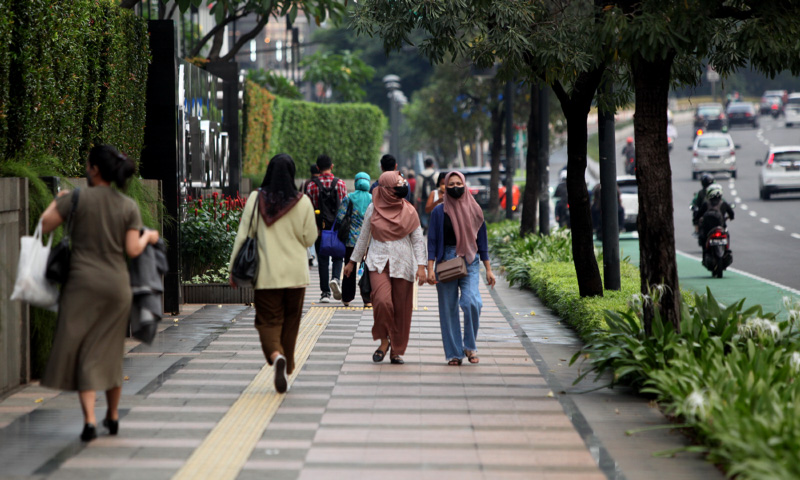

In [ ]:
im=Image.open('/content/sample_data/trotoar/pejalan_kaki/pejalan_kaki (20).jpg')
im

In [ ]:
"""Data Augmentation and Normalization for train images.Test and Val images are proccessed only with normalization"""
data_transforms = transforms.Compose([
        transforms.Resize(260),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.4508, 0.4365, 0.4216],[0.2561, 0.2542, 0.2592])
    ])

In [ ]:
data_dir = "/content/sample_data/trotoar"
dataset = datasets.ImageFolder(data_dir,transform = data_transforms)
"""Split dataset as train,test and val."""
train_size = int(len(dataset) * 0.77)
val_size = (len(dataset) - train_size) // 2
test_size = val_size
print(f"Train Size : {train_size} Val Size : {val_size} Test Size : {test_size}")

Train Size : 138 Val Size : 21 Test Size : 21


In [ ]:
"""Use random split to divide dataset."""
train_data,val_data,test_data = torch.utils.data.random_split(dataset,[train_size,val_size,test_size],
                                                              generator = torch.Generator().manual_seed(42))

class_names = train_data.dataset.classes

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data,batch_size = batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size = batch_size,shuffle = True)

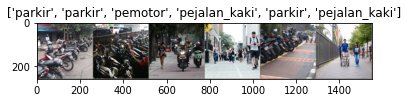

In [ ]:
import matplotlib.pyplot as plt
def imshow(inp,title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.4508, 0.4365, 0.4216])
    std = np.array([0.2561, 0.2542, 0.2592])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

"""Get a batch of training_data"""
inputs,classes = next(iter(test_loader))
"""Make a grid from batch."""
out = torchvision.utils.make_grid(inputs[0 : 6])
imshow(out,title = [class_names[x] for x in classes[0:6]])

In [ ]:
dataloaders = {"train" : train_loader,"val" : val_loader,"test" : test_loader}
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
dataset_sizes = {"train" : train_size,"val" : val_size,"test" : test_size}
def train_model(model,criterion,optimizer,scheduler,num_epochs = 25):
   #Define time and best model weights to save.
   since = time.time()
   best_model_wts = copy.deepcopy(model.state_dict())
   best_acc = 0.0
   for epoch in range(num_epochs):
     print(f"Epoch : {epoch+1} / {num_epochs }")
     print("-" * 10)
     #Each epoch has training and validation phase.
     for phase in ["train","val"]:
       if phase == "train":
         model.train()
       else:
         model.eval()
       running_loss = 0.0
       running_corrects = 0
       #Iterate over data.
       for inputs,labels in dataloaders[phase]:
         #Move tensors to gpu.
         inputs = inputs.to(device)
         labels = labels.to(device)
         #Zero Gradients.
         optimizer.zero_grad()
         #Forward
         #Track history if only in train.
         with torch.set_grad_enabled(phase == "train"):
           #Get preds in train and calculate loss.
           outputs = model(inputs)
           _,preds = torch.max(outputs,1)
           loss = criterion(outputs,labels)
           #Backward in train phase.
           if phase == "train":
             loss.backward()
             optimizer.step()
         #statistics
         running_loss += loss.item() * inputs.size(0)
         running_corrects += torch.sum(preds == labels.data)
    
       if phase == "train":
         scheduler.step()

       epoch_loss = running_loss / dataset_sizes[phase]
       epoch_acc = running_corrects.double() / dataset_sizes[phase]

       print(f"{phase} Loss : {epoch_loss} Acc {epoch_acc}")
       #Deep copy of the model.
       if phase == "val" and epoch_acc > best_acc:
         best_acc = epoch_acc
         best_model_wts = copy.deepcopy(model.state_dict())


     print()
  
   time_elapsed = time.time() - since
   print(f"Training completed in : {time_elapsed // 60}m in {time_elapsed % 60}")
   print(f"Best val acc : {best_acc}")

   #Load model best weights.
   model.load_state_dict(best_model_wts)
   return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_features = model_ft.fc.in_features
#Output layer
model_ft.fc = nn.Linear(in_features=num_features,out_features = len(class_names))
#Move to gpu and define loss.
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(),lr = 0.001,momentum = 0.9)
#Decay LR by a factor 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size = 10,gamma = 0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,10)

Epoch : 1 / 10
----------
train Loss : 1.1902856636738433 Acc 0.2971014492753623
val Loss : 1.2307299375534058 Acc 0.38095238095238093

Epoch : 2 / 10
----------
train Loss : 1.0813225214032158 Acc 0.39855072463768115
val Loss : 1.0472886562347412 Acc 0.5238095238095238

Epoch : 3 / 10
----------
train Loss : 0.896822660729505 Acc 0.6811594202898551
val Loss : 0.9352445006370544 Acc 0.5714285714285714

Epoch : 4 / 10
----------
train Loss : 0.7550895265910936 Acc 0.782608695652174
val Loss : 0.8122135996818542 Acc 0.6666666666666666

Epoch : 5 / 10
----------
train Loss : 0.5872533157251884 Acc 0.8768115942028986
val Loss : 0.6117679476737976 Acc 0.8571428571428571

Epoch : 6 / 10
----------
train Loss : 0.43631685687148053 Acc 0.9637681159420289
val Loss : 0.44548067450523376 Acc 0.9523809523809523

Epoch : 7 / 10
----------
train Loss : 0.3709123549254044 Acc 0.9347826086956522
val Loss : 0.38949862122535706 Acc 0.9047619047619048

Epoch : 8 / 10
----------
train Loss : 0.27261517142

In [ ]:
def visualize_model(model,num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders["val"]):
            #Move tensors to gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            #Forward
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            for j in range(inputs.size()[0]):
                #Show validation images and predictions.
                images_so_far += 1
                ax = plt.subplot(num_images // 2,2,images_so_far)
                ax.axis("off")
                ax.set_title(f"Predicted : {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
    model.training(mode = was_training)

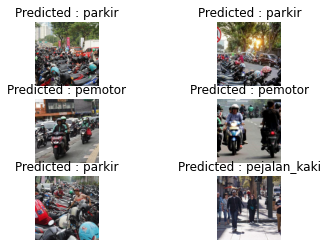

In [ ]:
visualize_model(model_ft,6)
plt.show()

In [ ]:
import os
torch.save(model.state_dict(),"wisnu_model_TFL.h5")

In [ ]:
model1 = model_ft
model1.load_state_dict(torch.load("wisnu_model_TFL.h5"))

<All keys matched successfully>

In [ ]:
from PIL import Image
import requests
from skimage import io
from io import BytesIO
def get_process_img(url):
    #Load image from url.
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    #Apply transform to image as train,test images.
    img = data_transforms(img)
    return img

In [ ]:
#Checking if there is GPU
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
model = model.to(device)
def pred_single_img(img):
    #Move img to device.
    img = img.to(device)
    #Prediction.
    outputs = model(img.unsqueeze(0))
    _,preds = torch.max(outputs,1)
    #Return prediction with using indexes.
    result = class_names[preds.item()]
    return result

Prediction is : parkir


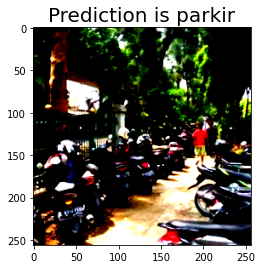

In [ ]:
"""Paste url and get img."""
url = "https://s3-ap-southeast-1.amazonaws.com/tigapilar/uploads/2017/08/02/YYpEWW2P-Parkir-Liar-di-Trotoar-765x510.jpg"
img = get_process_img(url)
"""Print pred."""
pred = pred_single_img(img)
title_pred = "Prediction is "
title_image = title_pred+pred
print(f"Prediction is : {pred}")
"""Show img."""
image = io.imread(url)
plt.title(title_image, fontsize = 20)
#plt.imshow(image)
#plt.show(pred)
plt.imshow(img.permute(1,2,0))
plt.show()